# Newsgroup Classification Using Logistic Regression

The goal of the project is to build and fine-tune multiple logistic regression models to classify posts by topics inferred from the text data from newsgroup posts on a variety of topics.

The dataset includes a total of 3,387 text-based examples collected from a newsgroup with various topics. Whereas with digit classification, where each input is relatively dense (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively sparse (represented as a bag-of-words). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

# additional libraries just for formatting the printout
import pandas as pd
from IPython.display import display, HTML
import warnings

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Part 1:

For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
#def P1(num_examples=5):
    ### STUDENT START ###
d = np.array(train_data)[0:5]
l = np.array(train_labels)[0:5]
c = np.array(newsgroups_train.target_names)[l]
df = pd.DataFrame({'Label': l, 'Category': c, 'Data': d})

# print df
pd.set_option('max_colwidth',10000)
df.style.set_properties(**{'text-align': 'left'})
s = df.style
s = s.set_properties(**{'text-align': 'left'}).set_table_styles([ 
        dict(selector='th', props=[('text-align', 'left')]) 
    ])
s = s.hide_index()
display(s)
    ### STUDENT END ###
#P1(5)

Label,Category,Data
1,comp.graphics,"Hi, I've noticed that if you only save a model (with all your mapping planes positioned carefully) to a .3DS file that when you reload it after restarting 3DS, they are given a default position and orientation. But if you save to a .PRJ file their positions/orientation are preserved. Does anyone know why this information is not stored in the .3DS file? Nothing is explicitly said in the manual about saving texture rules in the .PRJ file. I'd like to be able to read the texture rule information, does anyone have the format for the .PRJ file? Is the .CEL file format available from somewhere? Rych"
3,talk.religion.misc,"Seems to be, barring evidence to the contrary, that Koresh was simply another deranged fanatic who thought it neccessary to take a whole bunch of folks with him, children and all, to satisfy his delusional mania. Jim Jones, circa 1993. Nope - fruitcakes like Koresh have been demonstrating such evil corruption for centuries."
2,sci.space,">In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.com (Mark Brader) MB> So the MB> 1970 figure seems unlikely to actually be anything but a perijove. JG>Sorry, _perijoves_...I'm not used to talking this language. Couldn't we just say periapsis or apoapsis?"
0,alt.atheism,"I have a request for those who would like to see Charley Wingate respond to the ""Charley Challenges"" (and judging from my e-mail, there appear to be quite a few of you.) It is clear that Mr. Wingate intends to continue to post tangential or unrelated articles while ingoring the Challenges themselves. Between the last two re-postings of the Challenges, I noted perhaps a dozen or more posts by Mr. Wingate, none of which answered a single Challenge. It seems unmistakable to me that Mr. Wingate hopes that the questions will just go away, and he is doing his level best to change the subject. Given that this seems a rather common net.theist tactic, I would like to suggest that we impress upon him our desire for answers, in the following manner: 1. Ignore any future articles by Mr. Wingate that do not address the Challenges, until he answers them or explictly announces that he refuses to do so. --or-- 2. If you must respond to one of his articles, include within it something similar to the following: ""Please answer the questions posed to you in the Charley Challenges."" Really, I'm not looking to humiliate anyone here, I just want some honest answers. You wouldn't think that honesty would be too much to ask from a devout Christian, would you? Nevermind, that was a rhetorical question."
2,sci.space,"AW&ST had a brief blurb on a Manned Lunar Exploration confernce May 7th at Crystal City Virginia, under the auspices of AIAA. Does anyone know more about this? How much, to attend???? Anyone want to go?"


### Part 2:

Transform the training data into a matrix of **word** unigram feature vectors.  What is the size of the vocabulary? What is the average number of non-zero features per example?  What is the fraction of the non-zero entries in the matrix?  What are the 0th and last feature strings (in alphabetical order)?<br/>
_Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._

Now transform the training data into a matrix of **word** unigram feature vectors using your own vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. What is the average number of non-zero features per example?<br/>
_Use `CountVectorization(vocabulary=...)` and its `.transform` method._

Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._

Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(min_df=...)` and its `.fit_transform` method._

Now again transform the training data into a matrix of **word** unigram feature vectors. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?<br/>
_Hint: Build vocabularies for both train and dev and look at the size of the difference._

In [4]:
#def P2():
    ### STUDENT START ###    
# vectorization
cv = CountVectorizer()
x = cv.fit_transform(train_data)
col_names = cv.get_feature_names()

# find requested stats
n, voc_size = x.shape[0], x.shape[1]
avg_fea_per_ex = x.nnz / n
frac_nonzero = x.nnz / (n * voc_size)
fea_first = col_names[0]
fea_last = col_names[len(col_names) - 1]

# print results
print("PART 1 (Raw Unigram, Word):")
print('Size of the vocabulary: {:,}'.format(voc_size))
print('Avg number of non-zero features per example: {:.0f}'.format(avg_fea_per_ex))
print('Fraction of the non-zero entries: {:.4f}'.format(frac_nonzero))
print('0th feature strings: {}'.format(fea_first))
print('Last feature strings: {}'.format(fea_last))

# ----------------------------------------------------------------------
MY_VOC = ['atheism', 'graphics', 'space', 'religion']

# vectorization
cv = CountVectorizer(vocabulary = MY_VOC)
x = cv.fit_transform(train_data)
n, voc_size = x.shape[0], x.shape[1]
avg_fea_per_ex = x.nnz / n
print("\nPART 2 (Custom Vocabularies):")
print('Vocabularies: {}'.format(cv.get_feature_names()))
print('Size of the vocabulary: {:,}'.format(voc_size))
print('Avg number of non-zero features per example: {:.2f}'.format(avg_fea_per_ex))

# ----------------------------------------------------------------------
x_bigram = CountVectorizer(analyzer='char', 
                           ngram_range=[2, 2]).fit_transform(train_data)
x_trigram = CountVectorizer(analyzer='char', 
                            ngram_range=[3, 3]).fit_transform(train_data)
x_bi_tri = CountVectorizer(analyzer='char', 
                           ngram_range=[2, 3]).fit_transform(train_data)

print("\nPART 3 (Char Analyzer):")
print('Size of the vocabulary (char bigram): {:,}'.format(x_bigram.shape[1]))
print('Size of the vocabulary (char trigram): {:,}'.format(x_trigram.shape[1]))
print('Size of the vocabulary (char bigram/trigram): {:,}'.format(x_bi_tri.shape[1]))

# ----------------------------------------------------------------------
x = CountVectorizer(analyzer='word', min_df=10).fit_transform(train_data)
print("\nPART 4 (Filtered Word Analyzer):")
print('Size of the vocabulary (word unigram, frq < 10 removed): {:,}'.format(x.shape[1]))

# ----------------------------------------------------------------------
cv_train = CountVectorizer()
cv_dev = CountVectorizer()
cv_train.fit_transform(train_data)
cv_dev.fit_transform(dev_data)

fea_names_train = cv_train.get_feature_names()
fea_names_dev = cv_dev.get_feature_names()
num_of_train_vocs_in_dev = np.sum(np.isin(fea_names_dev, fea_names_train))
r = 1 - num_of_train_vocs_in_dev / len(fea_names_dev)

print("\nPART 5 (Missing Words in Dev):")
print('# of training vocabularies found in dev dataset: {:,d}'.format(num_of_train_vocs_in_dev))
print('Missing vocabularies ratio in dev dataset: {:.2f}'.format(r))
    ### STUDENT END ###

#P2()

PART 1 (Raw Unigram, Word):
Size of the vocabulary: 26,879
Avg number of non-zero features per example: 97
Fraction of the non-zero entries: 0.0036
0th feature strings: 00
Last feature strings: zyxel

PART 2 (Custom Vocabularies):
Vocabularies: ['atheism', 'graphics', 'space', 'religion']
Size of the vocabulary: 4
Avg number of non-zero features per example: 0.27

PART 3 (Char Analyzer):
Size of the vocabulary (char bigram): 3,291
Size of the vocabulary (char trigram): 32,187
Size of the vocabulary (char bigram/trigram): 35,478

PART 4 (Filtered Word Analyzer):
Size of the vocabulary (word unigram, frq < 10 removed): 3,064

PART 5 (Missing Words in Dev):
# of training vocabularies found in dev dataset: 12,219
Missing vocabularies ratio in dev dataset: 0.25


### Part 3:

Transform the training and development data to matrices of word unigram feature vectors.

1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score.
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.

* Why doesn't k-Nearest Neighbors work well for this problem?
* Why doesn't Logistic Regression work as well as Naive Bayes does?
* What is the relationship between logistic regression's sum of squared weights vs. C value?

In [5]:
#def P3():
    ### STUDENT START ###
# build training feature set
cv_train = CountVectorizer()
x_train = cv_train.fit_transform(train_data)

# build test feature set
cv_dev = CountVectorizer(vocabulary = cv_train.get_feature_names())
x_dev = cv_dev.fit_transform(dev_data)

# KNN
# ----------------------------------------------------------------------
def knn_predict(k: int, 
                train_data: np.ndarray, 
                train_labels: np.ndarray,
                x: np.ndarray = dev_data) -> np.ndarray:
    """Predict using k-nn.
    Return:
        (np.ndarray): Predicted labels.
    """
    m = KNeighborsClassifier()
    m.set_params(n_neighbors=k)
    m.fit(train_data, train_labels)
    return m.predict(x)

# build KNN models
print("Part 1 (KNN Model):")
f1s = []
for i in range(1, 100, 2):
    dev_pds = knn_predict(i, x_train, train_labels, x_dev)
    
    # micro f1 is the same as accuracy in this project because every 
    # test case is guaranteed to be assigned to EXACTLY one class).
    f1 = classification_report(dev_labels, dev_pds, output_dict=True)['accuracy']
    
    # only print the first 10 reports
    if i <= 20:
        print('K = {:.0f}, Micro F1 = {:.4f}'.format(i, f1))
    f1s.append({'k': i, 'f1': f1})

# find best f1
optimal = max(f1s, key=lambda x: x['f1'])

# print results
print('10 of the 50 models created (K = 1, 3, 5, ..., 99) are shown.')
print('The approx. optimal micro f1 value ({:.4f}) is found at k={}'. \
      format(optimal['f1'], optimal['k']))

# NB
# ----------------------------------------------------------------------
# remove warning message due to poor predictions
warnings.filterwarnings('ignore')

ALPHAS = (0, 1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 
          1, 2, 10, 100, 1000, 10000, 100000)

# build NB models
print("\nPart 2 (NB Model):")
f1s = []
for alpha in ALPHAS:    
    nb = MultinomialNB(alpha=alpha)
    nb.fit(x_train, train_labels)
    dev_pds = nb.predict(x_dev)
    
    f1 = classification_report(dev_labels, dev_pds, output_dict=True)['accuracy']
    print('alpha = {}, Micro F1 = {:.4f}'.format(alpha, f1))
    
    f1s.append({'alpha': alpha, 'f1': f1})

# find best f1
optimal = max(f1s, key=lambda x: x['f1'])

# print results
print('{} models were created.'.format(len(ALPHAS)))
print('The approx. optimal micro f1 value ({:.4f}) is found at alpha={}'. \
      format(optimal['f1'], optimal['alpha']))

# Logistic Regression
# ----------------------------------------------------------------------
C_ARR = [0.0001, 0.001, 0.01]
C_ARR.extend([i/10 for i in range(1, 11, 2)])
C_ARR.extend(list(range(1, 11)))
C_ARR.extend([100, 1000, 10000])

print("\nPart 3 (Logistic Regression):")
f1s = []
for c in C_ARR:
    lr = LogisticRegression(C=c, solver="liblinear", multi_class="auto")
    lr_m = lr.fit(x_train, train_labels)
    dev_pds = lr_m.predict(x_dev)
    
    f1 = classification_report(dev_labels, dev_pds, output_dict=True)['accuracy']
    ssw = np.round(np.sum(lr.coef_ ** 2, axis=1), 4).tolist()
    print('C = {}, F1 = {:.4f}, SSW = [{:.2f}, {:.2f}, {:.2f}, {:.2f}]'. \
          format(c, f1, ssw[0], ssw[1], ssw[2], ssw[3]))
    
    f1s.append({'f1': f1, 'c': c})

# print optimal result
optimal = max(f1s, key=lambda x: x['f1'])
print('{} models were created.'.format(len(f1s)))
print('The approx. optimal micro f1 value ({:.4f}) is found at C={:.2f} (or lambda={:.2f})'. \
      format(optimal['f1'], optimal['c'], 1/optimal['c']))
    ## STUDENT END ###
#P3()

Part 1 (KNN Model):
K = 1, Micro F1 = 0.3831
K = 3, Micro F1 = 0.4142
K = 5, Micro F1 = 0.4231
K = 7, Micro F1 = 0.4438
K = 9, Micro F1 = 0.4305
K = 11, Micro F1 = 0.4186
K = 13, Micro F1 = 0.4231
K = 15, Micro F1 = 0.4334
K = 17, Micro F1 = 0.4482
K = 19, Micro F1 = 0.4393
10 of the 50 models created (K = 1, 3, 5, ..., 99) are shown.
The approx. optimal micro f1 value (0.4763) is found at k=97

Part 2 (NB Model):
alpha = 0, Micro F1 = 0.7544
alpha = 1e-10, Micro F1 = 0.7544
alpha = 0.0001, Micro F1 = 0.7692
alpha = 0.001, Micro F1 = 0.7751
alpha = 0.01, Micro F1 = 0.7796
alpha = 0.1, Micro F1 = 0.7929
alpha = 0.5, Micro F1 = 0.7885
alpha = 1, Micro F1 = 0.7811
alpha = 2, Micro F1 = 0.7737
alpha = 10, Micro F1 = 0.6967
alpha = 100, Micro F1 = 0.5710
alpha = 1000, Micro F1 = 0.4127
alpha = 10000, Micro F1 = 0.3225
alpha = 100000, Micro F1 = 0.2959
14 models were created.
The approx. optimal micro f1 value (0.7929) is found at alpha=0.1

Part 3 (Logistic Regression):
C = 0.0001, F1 = 0.5

ANSWER:  
Q1  
**Why doesn't k-Nearest Neighbors work well?**  
KNN suffers from the curse of high dimensionality. The feature space is huge with thousands of vocabularies overlapping between the training and development datasets. All data points appear far away from each other in such high dimension.
  
Q2  
**Why doesn't Logistic Regression work as well as Naive Bayes does?**  
There are three plausible explanations:
In general, generative model (Naive Bayes) reaches its asymptotic optimal faster than the discriminative model (logistic regression) according to the [paper](https://ai.stanford.edu/~ang/papers/nips01-discriminativegenerative.pdf) published by Professor Andrew Ng and Professor Michael I Jordan. In the case Naive Bayes vs. logistic regression, prior probabilities would help Naive Bayes to converge to its optimal faster. In sum, it is highly possible that we just don't have enough examples for the logistic regression to converge. 
  
Q3  
**What is the relationship between logistic regression's sum of squared weights vs. C value?**  
The cost function of the logistic regression is:  
  
$J(\theta)=-\frac{1}{m} \sum_{i=1}^{m}\left[y^{(i)} \log \left(h_{\theta}\left(x^{(i)}\right)\right)+\left(1-y^{(i)}\right) \log \left(1-h_{\theta}\left(x^{(i)}\right)\right)\right]+\frac{\lambda}{2 m} \sum_{j=1}^{n} \theta_{j}^{2}$  
where $C = \frac{1}{\lambda}$ and $\theta_j$ is the jth weight being estimated by the logistic regression. 
  
That is:
- The larger $C$ is, the smaller $\lambda$ becomes, and the smaller the regularization term $\frac{\lambda}{2 m} \sum_{j=1}^{n} w_{j}^{2}$ becomes. As a result, the effect of regularization is reduced. When $C$ goes infinite,  $\lambda$ becomes zero and the effect of regularization is completely eliminated.
- The smaller $C$ is, the larger $\lambda$ becomes, and the larger the regularization term $\frac{\lambda}{2 m} \sum_{j=1}^{n} w_{j}^{2}$ becomes. As a result, the effect of regularization is increased. When $C$ goes zero,  $\lambda$ becomes infinite and the effect of regularization goes infinite (a rather meaningless setup because all weights would be driven to zero).


### Part 4:

Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.  For each topic, find the 5 features with the largest weights (that's 20 features in total).  Show a 20 row (features) x 4 column (topics) table of the weights.

Do you see any surprising features in this table?

In [6]:
#def P4():
    ### STUDENT START ###
# remove warning message due to poor predictions
warnings.filterwarnings('ignore')

# vectorize the features
cv = CountVectorizer(ngram_range=[2, 2])
x_train_bigram = cv.fit_transform(train_data)
fea_names = cv.get_feature_names()

# build regression
lr = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
lr_m = lr.fit(x_train_bigram, train_labels)

# extract info
coefs_all = lr_m.coef_
coefs_top5 = lr_m.coef_.argsort(axis=1)[:, ::-1][:, 0:5]
labels = newsgroups_train.target_names

# create the base table
df_coefs = pd.DataFrame(data=coefs_top5)
df_coefs['Category'] = labels
df_coefs = pd.melt(df_coefs, 
                   id_vars=['Category'],
                   value_vars=[0, 1, 2, 3, 4],
                   var_name='Rank', 
                   value_name='i')
df_coefs = df_coefs.sort_values(by=['Category', 'Rank']).reset_index(drop=True)
df_coefs['Bigram'] = df_coefs['i'].apply(lambda index: fea_names[index])

def get_col(df: pd.DataFrame, 
            col_name: str, 
            labels: list = labels,
            coefs: np.ndarray = coefs_all) -> pd.Series:
    """An ugly function that is used to specifically create new columns 
    of indices for the 4 topics as required.
    """
    # create a list of indices for the topic
    col = df.loc[:, 'i']
    
    # convert indices into cofficients
    i = labels.index(col_name)
    col = [coefs[i][coef_index] for coef_index in col]
    
    return col

# add the 4 topic columns
df_coefs['alt.atheism'] = get_col(df_coefs, 'alt.atheism')
df_coefs['comp.graphics'] = get_col(df_coefs, 'comp.graphics')
df_coefs['sci.space'] = get_col(df_coefs, 'sci.space')
df_coefs['talk.religion.misc'] = get_col(df_coefs, 'talk.religion.misc')

# refine/reorder/drop columns
df_coefs['Rank'] += 1
df_coefs = df_coefs.loc[:, ['Category', 
                            'Bigram', 
                            'Rank', 
                            'alt.atheism', 
                            'comp.graphics', 
                            'sci.space', 
                            'talk.religion.misc']]
# a random agg function is applied, which should have no effect because 
# no values are aggregrated
df_coefs = df_coefs.groupby(['Category', 'Rank', 'Bigram']).median()

# highlight the top-5 coefficients in each category
def highlight_max(x):
    return ['color: #ff8c00' if i[0] == x.name else '' for i, _ in x.iteritems()]
s = df_coefs.style.apply(highlight_max)

# top align cell (fot the Category index column)
s.set_table_styles([
    {'selector': 'th',
     'props': [
         ('vertical-align','top')]}]
)
s.format({
    'alt.atheism': '{:,.2f}'.format,
    'comp.graphics': '{:,.2f}'.format,
    'sci.space': '{:,.2f}'.format,
    'talk.religion.misc': '{:,.2f}'.format
})
HTML(s.render())
    ### STUDENT END ###
#P4()

ANSWER:  
The regression does a good job on optimizing the coefficients. The top-5 bigrams in each category generally have significantly larger, positive coefficients than they are in other categories. However, there are a few surprises observed:
- Certain words such as "cheers kent," appear significant in both "alt.atheism" and "talk.religion.misc." 
- A good portion of the top word bigrams are just generic phrases such as "you are," "are you," "it was," etc. This is not ideal; for example, the model might not generalize well if "alt.atheism" relies on keywords such as "was just," "you are," and "are you" for the prediction.
- Why is the #1 word bigram in talk.religion.misc "the fbi?" Are people discussing cults that are targeted by FBI?
- What does "cheers kent" mean? Why is the token heavily discussed in religion and atheism?
- "ignorance is" is #3 on talk.religion.misc. Are people trashing each other's belief?

### Part 5:

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

Produce a Logistic Regression model (with no preprocessing of text).  Evaluate and show its f1 score and size of the dictionary.

Produce an improved Logistic Regression model by preprocessing the text.  Evaluate and show its f1 score and size of the vocabulary.  Try for an improvement in f1 score of at least 0.02.

How much did the improved model reduce the vocabulary size?

In [7]:
#def better_preprocessor(s):
    ### STUDENT START ###
def better_preprocessor(doc: str) -> np.ndarray:
    """Function to preprocess words.
    """
    doc = doc.lower() # lower the case
    # somehow removing emails don't help...
    # doc = re.sub(r'\S*@\S*\s?', 'email ', doc) # treat all emails as the same thing
    doc = re.sub(r'[^\w\s]+|_+', ' ', doc) # remove non-alphanumeric characters
    doc = re.sub(r'[0-9]{1,}', 'number', doc) # treat all numbers as the same thing
    doc = re.sub(r'<[^>]*>', '', doc) # remove all HTML tags
    doc = re.sub(r'-+', ' ', doc) # split words with dash
    
    # stem & remove stop words
    # Note: somehow removing stop words in here in addition to 
    # CountVectorizer's stop_word='english' helps improve f1 significantly...
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = doc.split()
    tokens = [w for w in tokens if w not in stop_words]
    # options: PorterStemmer & LancasterStemmer
    tokens = [nltk.stem.PorterStemmer().stem(w) for w in tokens]
    doc = ' '.join(tokens)
        
    return doc
    ### STUDENT END ###

#def P5():
    ### STUDENT START ###
# model 1
cv_train = CountVectorizer()
x_train = cv_train.fit_transform(train_data)
cv_dev = CountVectorizer(vocabulary=cv_train.get_feature_names())
x_dev = cv_dev.fit_transform(dev_data)

lr = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
lr_m = lr.fit(x_train, train_labels)
dev_pds = lr_m.predict(x_dev)

voc_size_1 = x_train.shape[1]
f1_1 = metrics.f1_score(dev_labels, dev_pds, average="weighted")

# model 2
cv_train_2 = CountVectorizer(preprocessor=better_preprocessor, 
                             stop_words='english')
x_train_2 = cv_train_2.fit_transform(train_data)
cv_dev_2 = CountVectorizer(vocabulary=cv_train_2.get_feature_names(),
                           preprocessor=better_preprocessor,
                           stop_words='english')
x_dev_2 = cv_dev_2.fit_transform(dev_data)

lr_2 = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
lr_m_2 = lr.fit(x_train_2, train_labels)
dev_pds_2 = lr_m.predict(x_dev_2)

voc_size_2 = x_train_2.shape[1]
f1_2 = metrics.f1_score(dev_labels, dev_pds_2, average="weighted")

print('Model 1:')
print('Vocabulary Size: {:,d}'.format(voc_size_1))
print('F1 = : {:.4f}'.format(f1_1))
print('\nModel 2:')
print('Vocabulary Size: {:,d}'.format(voc_size_2))
print('F1 = : {:.4f}'.format(f1_2))
print('\nF1 Improvement: {:.4f}'.format(f1_2 - f1_1))
    ### STUDENT END ###

#P5()

Model 1:
Vocabulary Size: 26,879
F1 = : 0.7085

Model 2:
Vocabulary Size: 16,887
F1 = : 0.7401

F1 Improvement: 0.0317


ANSWER:  
F1 improves by 0.0317 and the vocabulary size drops from 26,879 to 16,887 after the transformation.

### Part 6:

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, L1 regularization drives many of the weights to 0, effectively removing unimportant features.

For several L1 regularization strengths ...<br/>
* Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.  Produce a new Logistic Regression model using the reduced vocabulary and **L2** regularization strength of 0.5.  Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.

Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.

How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Building model 1 of 12...
Building model 2 of 12...
Building model 3 of 12...
Building model 4 of 12...
Building model 5 of 12...
Building model 6 of 12...
Building model 7 of 12...
Building model 8 of 12...
Building model 9 of 12...
Building model 10 of 12...
Building model 11 of 12...
Building model 12 of 12...

Results:


L1 Lambda,L1 C,L2 C,F1 (Full),F1 (Reduced),Vocabulary Size (Full),Vocabulary Size (Reduced)
0.10,10.00,0.50,0.66,0.67,26879,3326
0.30,3.33,0.50,0.69,0.68,26879,2260
0.90,1.11,0.50,0.69,0.69,26879,1621
0.50,2.00,0.50,0.69,0.69,26879,1517
1.00,1.00,0.50,0.69,0.70,26879,1394
0.70,1.43,0.50,0.69,0.70,26879,1307
3.00,0.33,0.50,0.69,0.69,26879,557
5.00,0.20,0.50,0.68,0.69,26879,370
7.00,0.14,0.50,0.67,0.67,26879,296
9.00,0.11,0.50,0.67,0.66,26879,231


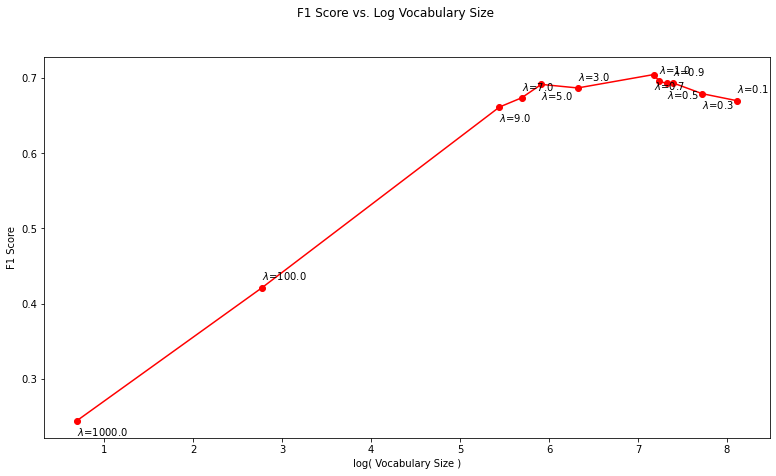

In [8]:
#def P6():
    # Keep this random seed here to make comparison easier.
    #np.random.seed(0)
    
    ### STUDENT START ###
LAMBDAS = [i/10 for i in range(1, 11, 2)]
LAMBDAS.extend(list(range(1, 11, 2)))
LAMBDAS.extend([100, 1000])

# baseline training features
cv_train = CountVectorizer()
x_train = cv_train.fit_transform(train_data)

# full voc df
df = pd.DataFrame(data=np.empty(0, dtype=[('L1 Lambda', 'float'), 
                                          ('Vocabulary Size (Full)', 'int'),
                                          ('F1 (Full)', 'float')]))
# reduced voc df
df_r = pd.DataFrame(data=np.empty(0, dtype=[('L1 Lambda', 'float'), 
                                            ('Vocabulary Size (Reduced)', 'int'),
                                            ('F1 (Reduced)', 'float')]))
for i, lambda_ in enumerate(LAMBDAS):
    # model 1 starts here...
    # build raw model
    lr = LogisticRegression(C=1/lambda_, 
                            penalty="l1",
                            tol=0.015,
                            solver="liblinear", 
                            multi_class="auto")
    lr_m = lr.fit(x_train, train_labels)
    
    # raw model predictions
    cv_dev = CountVectorizer(vocabulary=cv_train.get_feature_names())
    x_dev = cv_dev.fit_transform(dev_data)
    dev_pds = lr_m.predict(x_dev)
    
    # store raw model results
    voc_size = x_train.shape[1]
    f1 = metrics.f1_score(dev_labels, dev_pds, average="weighted")
    df.loc[i] = [lambda_, voc_size, f1]
    
    # model 2 starts here...
    # get new vocabularies
    i_non_zero = (np.sum(lr_m.coef_, axis=0) != 0)
    vocs_new = np.array(cv_train.get_feature_names())[i_non_zero]
    
    # build new model using new vocabularies
    cv_train_2 = CountVectorizer(vocabulary=vocs_new)
    x_train_2 = cv_train_2.fit_transform(train_data)
    lr_2 = LogisticRegression(C=0.5, 
                              penalty="l2",
                              tol=0.015,
                              solver="liblinear", 
                              multi_class="auto")
    lr_m_2 = lr.fit(x_train_2, train_labels)
    
    # new model predictions
    cv_dev = CountVectorizer(vocabulary=vocs_new)
    x_dev = cv_dev.fit_transform(dev_data)
    dev_pds = lr_m_2.predict(x_dev)
    
    # store results
    voc_size = x_train_2.shape[1]
    f1 = metrics.f1_score(dev_labels, dev_pds, average="weighted")
    df_r.loc[i] = [lambda_, voc_size, f1]
    print('Building model {} of {}...'.format(i+1, len(LAMBDAS)))

# merge model 1 & 2 results
df = df.astype({'Vocabulary Size (Full)': 'int'})
df_r = df_r.astype({'Vocabulary Size (Reduced)': 'int'})
df_r = df_r.sort_values(by=['Vocabulary Size (Reduced)', 'L1 Lambda'], 
                        ascending=False, ignore_index=True)
df_merge = pd.merge(df_r, df, on='L1 Lambda', how='left')
df_merge['L1 C'] = 1 / df_merge["L1 Lambda"]
df_merge['L2 C'] = 0.5
df_merge = df_merge.iloc[:, [0, 5, 6, 4, 2, 3, 1]]

print("\nResults:")
pd.options.display.float_format = '{:,.2f}'.format
display(HTML(df_merge.to_html(index=False)))
print('')

# plot performance metrics
fig, ax = plt.subplots(figsize=(13, 7))
fig.suptitle('F1 Score vs. Log Vocabulary Size')
ax.plot(np.log(df_merge['Vocabulary Size (Reduced)']), 
        df_merge['F1 (Reduced)'], 
        color='r', 
        linestyle='solid', 
        marker = 'o', 
        label='accuracy')
ax.set_ylabel('F1 Score')
ax.set_xlabel('log( Vocabulary Size )')

# add annotations
for i, lambda_ in enumerate(df_merge['L1 Lambda'].tolist()):
    txt = r'$\lambda$={}'.format(lambda_)
    x = np.log(df_merge.loc[i, 'Vocabulary Size (Reduced)'])
    y = df_r.loc[i, 'F1 (Reduced)']
    y_adj = 0.01
    if i % 2 == 1:
        y_adj = -0.02
    ax.annotate(txt, (x, y + y_adj))
pass
    ### STUDENT END ###
#P6()

ANSWER:  
Performance Comparison: Full-Vocabularies vs. Reduced-Vocabularies
- The f1 score from Part 3 is 0.7145 when C is set to 0.5. This score beats all f1 scores produced by the reduced-vocabularies model in Part 6. 
    - The result is expected because L1 is generally seen as a more "harsh" version of L2, and, in our case, unnecessarily drives weights to zero. 
    - The undesirable harsh L1 regularization effect is especially obvious when the C goes small and eliminates most of the features for prediction. 
- On the other hand, the f1 scores are roughly equal across all regularization strengths when comparing the two models (L1 vs. L2) in Part 6. This is also expected because two models essentially remove exactly the same vocabularies from the feature set.

F1 Trend Observation:
- Increase in L1 $\lambda$ leads to a decrease in vocabulary size. 
- F1 improves as L1 $\lambda$ increases only till a certain threshold. F1 generally decreases afterwards.
- The observation makes sense because an increase in L1 $\lambda$ improves the issue of overfitting with generalization. Too much generalization, however, hurts the model's prediction power.


### Part 7:

How is `TfidfVectorizer` different than `CountVectorizer`?

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

Show the 3 documents with highest R ratio, where ...<br/>
$R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$

Explain what the R ratio describes.  What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [9]:
#def P7():
    ### STUDENT START ###
C = 100

# ----------------------------------------------------------------------
# Model 1 - CountVectorizer
# transform features
cv_train = CountVectorizer()
x_train_cv = cv_train.fit_transform(train_data)
cv_dev = CountVectorizer(vocabulary=cv_train.get_feature_names())
x_dev_cv = cv_dev.fit_transform(dev_data)

# train model
lr_cv = LogisticRegression(C=C, 
                           penalty="l2",
                           solver="liblinear", 
                           multi_class="auto")
lr_m_cv = lr_cv.fit(x_train_cv, train_labels)

# f1
predictions_cv = lr_m_cv.predict(x_dev_cv)
f1_cv = metrics.f1_score(dev_labels, predictions_cv, average="weighted")

# r ratio
predictions_prob_cv = lr_m_cv.predict_proba(x_dev_cv)
max_prob_cv = np.max(predictions_prob_cv, axis=1)
correct_prob_cv = predictions_prob_cv[np.arange(0, dev_labels.shape[0]), dev_labels]
r_arr_cv = max_prob_cv / correct_prob_cv
r_top3_cv = r_arr_cv.flatten()[np.argsort(r_arr_cv, axis=None)][::-1][0:3]

print("Model 1 (CountVectorizer):")
print("F1: {:.4f}".format(f1_cv))
print("Top 3 documents by R Ratio:")
print("R = {:.2e}, {:.2e}, {:.2e}".format(r_top3_cv[0], r_top3_cv[1], r_top3_cv[2]))

# ----------------------------------------------------------------------
# Model 2 - TfidfVectorizer
# transform features
tv_train = TfidfVectorizer()
x_train_tv = tv_train.fit_transform(train_data)
tv_dev = TfidfVectorizer(vocabulary=tv_train.get_feature_names())
x_dev_tv = tv_dev.fit_transform(dev_data)

# train model
lr_tv = LogisticRegression(C=C, 
                           penalty="l2",
                           solver="liblinear", 
                           multi_class="auto")
lr_m_tv = lr_tv.fit(x_train_tv, train_labels)

# f1
predictions_tv = lr_m_tv.predict(x_dev_tv)
f1_tv = metrics.f1_score(dev_labels, predictions_tv, average="weighted")

# r ratio
predictions_prob_tv = lr_m_tv.predict_proba(x_dev_tv)
max_prob_tv = np.max(predictions_prob_tv, axis=1)
correct_prob_tv = predictions_prob_tv[np.arange(0, dev_labels.shape[0]), dev_labels]
r_arr_tv = max_prob_tv / correct_prob_tv

# indexing
index_by_r = np.argsort(r_arr_tv, axis=None)[::-1][0:3]
r_top3_tv = r_arr_tv[index_by_r]
doc_top3 = np.array(dev_data)[index_by_r]
correct_labels_top3 = np.array(dev_labels)[index_by_r]
predicted_labels_top3 = predictions_tv[index_by_r]

# print resutls
tn = newsgroups_test.target_names
print("")
print("Model 2 (TfidfVectorizer):")
print("F1: {:.4f}".format(f1_tv))
print("Top 3 documents by R Ratio:")
print("R = {:.2f}, {:.2f}, {:.2f}".format(r_top3_tv[0], r_top3_tv[1], r_top3_tv[2]))

print("\n#1")
print("------------------------------------------------")
print("R = {:.2f}".format(r_top3_tv[0]))
print("Correct Topic:", tn[correct_labels_top3[0]])
print("Predicted Topic:", tn[predicted_labels_top3[0]])
print(doc_top3[0])

print("\n#2")
print("------------------------------------------------")
print("R = {:.2f}".format(r_top3_tv[1]))
print("Correct Topic:", tn[correct_labels_top3[1]])
print("Predicted Topic:", tn[predicted_labels_top3[1]])
print(doc_top3[1])

print("#3")
print("------------------------------------------------")
print("R = {:.2f}".format(r_top3_tv[2]))
print("Correct Topic:", tn[correct_labels_top3[2]])
print("Predicted Topic:", tn[predicted_labels_top3[2]])
print(doc_top3[2])
    ### STUDENT END ###
#P7()

Model 1 (CountVectorizer):
F1: 0.6800
Top 3 documents by R Ratio:
R = 2.54e+36, 2.23e+22, 5.80e+19

Model 2 (TfidfVectorizer):
F1: 0.7568
Top 3 documents by R Ratio:
R = 1010.92, 386.43, 358.76

#1
------------------------------------------------
R = 1010.92
Correct Topic: talk.religion.misc
Predicted Topic: comp.graphics
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcom

ANSWER:
- **How is TfidfVectorizer different than CountVectorizer?**  
  CountVectorizer counts tokens while TFIDFVectorizer is CountVectorizer times the inversed toekn-frequency across all documents. This means that the more frequently the toekn appears across all the dataset, the more severely the token's score will be penalized. The effect is that TFIDFVectorizer downplays the importance of the tokens that appear frequently across multiple documents in the dataset.
  
  
- **Evaluate and show the f1 score.**  
    - TfidfVectorizer improves F1 score improves significantly (from 0.68 to 0.76). The additional penalization imposed by TfidfVectorizer seems to work well before feature transformations such as stop words removal are applied. 
  
  
- **Explain what the R ratio describes.**  
    - Mathmetically:
        - R ratio equals to 1 if the model makes a right prediction.
        - R ratio becomes larger than 1 if the model makes a wrong predction.
        - R ratio increases with the "wrongfulness" of the prediction. For example, R ratio becomes infinite if a probability of zero is assigned to the correct label.
    - Intuitively:
        - R measures "how wrong" the prediction is. The larger the R ratio is, the more wrong the prediction is.


- **What kinds of mistakes is the model making?**
    - Looking at the top 3 examples by R ratio, one major issue is that the model predicts "comp.graphics" when technocal keywords such as "ftp," "ASCII," and "rtf" are mentioned. 
    
    
- **Suggest a way to address one particular issue that you see.**  
    - The goals are threefold:
        - Ideally, we want to predict correctly. 
        - We should at least aim to lower the r ratios for wrong predictions if correct predictions are impossible due to the overwhelming number of keywords from other categories.
        - We should also see an overall improvement of the F1 value after optimization.  
    - Things to try:
        - **N-gram Transformation** should allow weights to be assigned to new tokens such as "Book of Mormon" or "Lynn Matthews Anderson."
        - **Words Reduction** (such as stemming, stop wrods removal, etc.) combined with TfidfVectorizer should allow the model to put more emphesis on important keywards that matter. 
        - **Regularization** may or may not help. Our best educated guess is to increase the regularization strength (i.e. a smaller C with larger lambda) so that the model would pue less emphesis on a few select technical keywords shown by the top 3 examples by R ratio.
    - Restuls (Part 8): 
        - R ratios drop for al three top 3 cases. The R ratio for Case #1 drops from 1010.92 to 473.61. Case #3 from Part 7 (with a R ratio of 358.76 and keywords such "ftp") has its R ratios dopped so low that it is now out of top 3.  
        - Also note that in Part 8, two of the top three cases are now predicted wrong because of the model's confusion between "religion" and "atheism." While still not ideal, we beleive that this is an improvement from Part 7's confusion between "religion" and "comp.graphics."
        - Lastly, F1 improves slightly by a scale of 0.0152.

### Part 8 EXTRA CREDIT:

Produce a Logistic Regression model to implement your suggestion from Part 7.

In [10]:
C = 50
NGRAM_RANGE = [1, 2]
F_VALUE_PART_7 = 0.7568

def better_preprocessor(doc: str) -> np.ndarray:
    """Function to preprocess words.
    """
    doc = doc.lower() # lower the case
    doc = re.sub(r'[^\w\s]+|_+', ' ', doc) # remove non-alphanumeric characters
    doc = re.sub(r'[0-9]{1,}', 'number', doc) # treat all numbers as the same thing
    doc = re.sub(r'<[^>]*>', '', doc) # remove all HTML tags
    doc = re.sub(r'-+', ' ', doc) # split words with dash
    
    # stem & remove stop words
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = doc.split()
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [nltk.stem.PorterStemmer().stem(w) for w in tokens]
    doc = ' '.join(tokens)
        
    return doc

# transform features
tv_train = TfidfVectorizer(preprocessor=better_preprocessor, 
                           stop_words='english',
                           max_df=0.25,
                           ngram_range=NGRAM_RANGE)
x_train_tv = tv_train.fit_transform(train_data)
tv_dev = TfidfVectorizer(vocabulary=tv_train.get_feature_names(),
                         preprocessor=better_preprocessor, 
                         stop_words='english',
                         max_df=0.25,
                         ngram_range=NGRAM_RANGE)
x_dev_tv = tv_dev.fit_transform(dev_data)

# train model
lr_tv = LogisticRegression(C=C, 
                           penalty="l2",
                           solver="liblinear", 
                           multi_class="auto")
lr_m_tv = lr_tv.fit(x_train_tv, train_labels)

# f1
predictions_tv = lr_m_tv.predict(x_dev_tv)
f1_tv = metrics.f1_score(dev_labels, predictions_tv, average="weighted")

# r ratio
predictions_prob_tv = lr_m_tv.predict_proba(x_dev_tv)
max_prob_tv = np.max(predictions_prob_tv, axis=1)
correct_prob_tv = predictions_prob_tv[np.arange(0, dev_labels.shape[0]), dev_labels]
r_arr_tv = max_prob_tv / correct_prob_tv

# indexing
index_by_r = np.argsort(r_arr_tv, axis=None)[::-1][0:3]
r_top3 = r_arr_tv[index_by_r]
doc_top3 = np.array(dev_data)[index_by_r]
correct_labels_top3 = np.array(dev_labels)[index_by_r]
predicted_labels_top3 = predictions_tv[index_by_r]


tn = newsgroups_test.target_names
print("F1: {:.4f}".format(f1_tv))
print("F1 Improvement (vs. Part 7): {:.4f}".format(f1_tv - F_VALUE_PART_7))
print("Vocubulary Size: {:,d}".format(len(tv_train.get_feature_names())))

print("")
print("Top 3 Documents by R Ratio:")
print("")

print("#1")
print("---------------------------------")
print("R = {:.2f}".format(r_top3[0]))
print("Correct Topic:", tn[correct_labels_top3[0]])
print("Predicted Topic:", tn[predicted_labels_top3[0]])
print(doc_top3[0])

print("\n#2")
print("---------------------------------")
print("R = {:.2f}".format(r_top3[1]))
print("Correct Topic:", tn[correct_labels_top3[1]])
print("Predicted Topic:", tn[predicted_labels_top3[1]])
print(doc_top3[1])

print("#3")
print("---------------------------------")
print("R = {:.2f}".format(r_top3[2]))
print("Correct Topic:", tn[correct_labels_top3[2]])
print("Predicted Topic:", tn[predicted_labels_top3[2]])
print(doc_top3[2])

F1: 0.7720
F1 Improvement (vs. Part 7): 0.0152
Vocubulary Size: 163,905

Top 3 Documents by R Ratio:

#1
---------------------------------
R = 473.61
Correct Topic: talk.religion.misc
Predicted Topic: comp.graphics
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy